# Reconhecimento de Dígitos
## 1. Preparação do Ambiente

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\gabri\AppData\Local\Temp\ipykernel_20592\2660915427.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
TEST_DATA_PATH = ('dados/test.csv')
TRAIN_DATA_PATH = ('dados/train.csv')
data_test_df = pd.read_csv(TEST_DATA_PATH, sep=';')
data_train_df = pd.read_csv(TRAIN_DATA_PATH, sep=';')

## 2. Redução da dimensão das amostras
### 2.1. Intensidade e simetria da imagem

In [3]:
def calcular_intensidade_e_simetria(row):
    # Começa na segunda coluna da linha convertendo os valores para array e remodela para o formato 28x28
    pixelx = row[1:].values.reshape(28, 28)
    
    # Soma todos os valores da linha e depois divide por 255 
    intensidade = pixelx.sum() / 255

    # Calcula a soma dos valores absolutos das diferenças entre cada pixel e seu correspondente do lado oposto 
    # verticalmente.
    # Isso é feito pegando todas as linhas (':') e as primeiras metades das colunas (':14'), 
    # e subtraindo isso do espelhamento horizontal das mesmas linhas e metades das colunas.
    # O espelhamento é feito com '[:, ::-1]' que inverte a ordem das colunas e '[:, :14]' pega a metade espelhada.
    simetria_vertical = np.sum(np.abs(pixelx[:, :14] - pixelx[:, ::-1][:, :14])) / 255
    # É semelhante ao cálculo da simetria vertical, pegamos metades das linhas com '[:14, :]' e espelhamos 
    # no eixo horizontal com '[::-1, :]', depois pegamos a metade superior das linhas espelhadas com '[:14, :]' 
    # para fazer a subtração.
    simetria_horizontal = np.sum(np.abs(pixelx[:14, :] - pixelx[::-1, :][:14, :])) / 255
    simetria_completa = simetria_vertical + simetria_horizontal
    
    return pd.Series({'intensidade': intensidade, 'simetria': simetria_completa})

data_train_df[['intensidade', 'simetria']] = data_train_df.apply(calcular_intensidade_e_simetria, axis=1)
data_test_df[['intensidade', 'simetria']] = data_test_df.apply(calcular_intensidade_e_simetria, axis=1) 

In [4]:
colunas_relevantes = ['label', 'intensidade', 'simetria']
TEST_REDU_DATA_PATH = ('dados/test_redu.csv')
TRAIN_REDU_DATA_PATH = ('dados/train_redu.csv')

data_test_df[colunas_relevantes].to_csv('dados/test_redu.csv', index=False)
data_train_df[colunas_relevantes].to_csv('dados/train_redu.csv', index=False)

In [5]:
data_test_redu_df = pd.read_csv(TEST_REDU_DATA_PATH)
data_train_redu_df = pd.read_csv(TRAIN_REDU_DATA_PATH)

## 3. Classificação dos dígitos 1x5
### 3.1. Filtragem dos dados

In [6]:
data_test_redu_filtered_df = data_test_redu_df[(data_test_redu_df['label'] == 1) | (data_test_redu_df['label'] == 5)]
data_train_redu_filtered_df = data_train_redu_df[(data_train_redu_df['label'] == 1) | (data_train_redu_df['label'] == 5)]

### 3.2. Plotagem de dados de train1x5

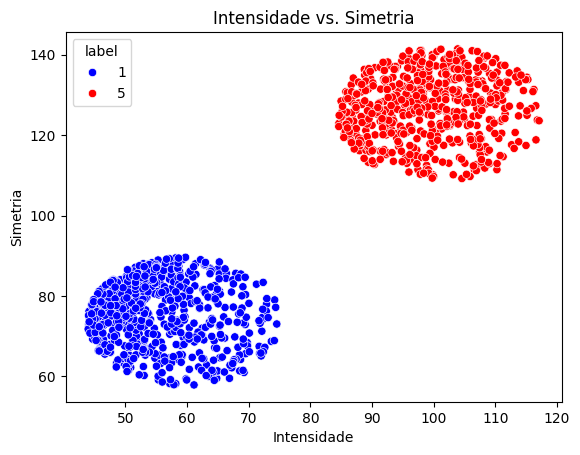

In [7]:
def plotagem_grafico_1x5(data_train_redu_filtered_df):
    sns.scatterplot(data_train_redu_filtered_df, x='intensidade', y='simetria', hue='label', palette={1: 'blue', 5: 'red'})
    plt.title('Intensidade vs. Simetria')
    plt.xlabel('Intensidade')
    plt.ylabel('Simetria')

plotagem_grafico_1x5(data_train_redu_filtered_df)

### 3.3 Preparação de `X` e `y`

In [8]:
# Transformação para arrays nos dados de treinamento a partir da coluna 1.
X_train = data_train_redu_filtered_df.iloc[:, 1:].values
# X_train é subtraído pelo cáluclo da média de cada coluna de X_train, 
# logo após essa subtração, acontece a divisão pelo cálculo do desvio padrão de cada coluna.
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
        
# Transformação para arrays nos dados de treinamento somente da coluna 0
y_train = data_train_redu_filtered_df.iloc[:, 0].values
# Definição de 1 quando o valor nos dados forem 1 e -1 para todos os outros dados.
y_train = np.where(y_train == 1, 1, -1)

### 3.4.1. Plotagem do modelo **Perceptron**

100%|██████████| 200/200 [00:01<00:00, 142.05it/s]


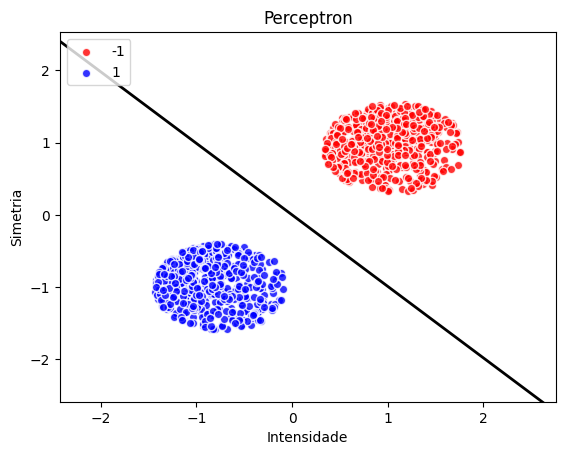

In [9]:
from modelos_lineares.perceptron import Perceptron

perceptron = Perceptron(taxa_aprendizado=0.01, n_iteracoes=200)
perceptron.ajuste(X_train, y_train)
perceptron.plotagem_perceptron(X_train, y_train, classifier=perceptron)

### 3.4.2. Plotagem do modelo **Regressão Linear**

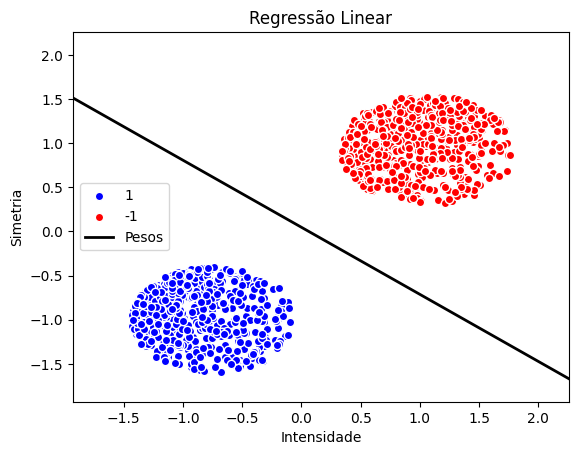

In [10]:
from modelos_lineares.regressao_linear import RegressaoLinear

regressao_linear = RegressaoLinear(taxa_aprendizado=0.01, n_iteracoes=10000)
regressao_linear.ajuste(X_train, y_train)   
regressao_linear.plotagem_regressao_linear(X_train, y_train)

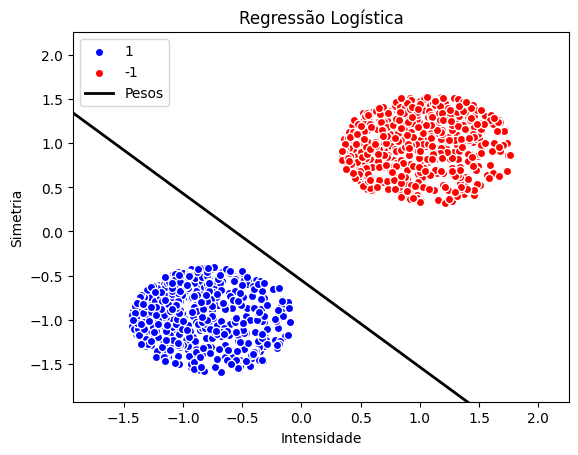

In [26]:
from modelos_lineares.regressao_logistica import RegressaoLogistica

regressao_logistica = RegressaoLogistica(taxa_aprendizado=0.001, n_iteracoes=1000)
regressao_logistica.ajuste(X_train, y_train) 
regressao_logistica.plotagem_regressao_logistica(X_train, y_train)